## Shiyu's Notebook for beta weighting model and mean variance optimization model for constructing a portfolio. ##
The new portfolio is constructed of 3 ETFs with an initial investment of $200. 
Use time-series-data from Feburary 2020 to Feburary 2021. 

The goal is to use beta weighting model with python codes to calculate the weighted beta for each ETF with a targeted beta to reduce portfolio risk. The mean variance optimization tells the expected return for the portfolio and optimize the return and minimize the risks. 

First of all, import all the coding and visualization packages needed. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline
regr = LinearRegression()
from scipy.optimize import minimize

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
plt.rcParams['figure.figsize'] = [15,12]

The three ETFs are "Global X Robotics & Artificial Intelligence ETF", "Global X Funds Global X Autonomous & Electric Vehicles ETF", and "SPDR Portfolio S&P 500 Growth ETF". I chose them because of the growth opportunities and potential in those industries. 

The data source is from Yahoo Finance, and stored in the file of "stocks". Use S&P 500 index as the benchmark for modeling. 

In [4]:
etf_list = 'botz driv spyg spy'.upper().split()

In [5]:
etf_data = []
for etf in etf_list: 
    df = pd.read_csv('C:/Users/HUA_SHIY/stocks/{}.csv'.format(etf))
    etf_data.append(df['Adj Close'])
    etf_prices = pd.DataFrame(etf_data).T
    etf_prices.index = df['Date']

In [6]:
etf_prices.columns = etf_list
etf_prices.index = pd.to_datetime(etf_prices.index)
etf_prices

,BOTZ,DRIV,SPYG,SPY
Date,,,,
2020-02-05,22.389015,15.400795,43.848541,326.757843
2020-02-06,22.478771,15.431658,44.145081,327.857330
2020-02-07,22.179585,15.132980,43.907845,326.109955
2020-02-10,22.518661,15.307209,44.421852,328.544495
2020-02-11,22.867712,15.521261,44.382317,329.113861
...,...,...,...,...
2021-01-29,33.849998,25.900000,55.040001,370.070007
2021-02-01,34.580002,26.600000,56.240002,376.230011
2021-02-02,35.070000,26.959999,57.070000,381.549988


Calculate the percentage return for each day.

In [7]:
etf_returns = etf_prices.pct_change().dropna()
etf_returns

,BOTZ,DRIV,SPYG,SPY
Date,,,,
2020-02-06,0.004009,0.002004,0.006763,0.003365
2020-02-07,-0.013310,-0.019355,-0.005374,-0.005330
2020-02-10,0.015288,0.011513,0.011706,0.007465
2020-02-11,0.015501,0.013984,-0.000890,0.001733
2020-02-12,0.005669,0.016677,0.008018,0.006443
...,...,...,...,...
2021-01-29,-0.026740,-0.029963,-0.020292,-0.020020
2021-02-01,0.021566,0.027027,0.021802,0.016646
2021-02-02,0.014170,0.013534,0.014758,0.014140


Before modeling, plot the graphs to see the return trend for each ETF against S&P500 for the year 2020-2021. 

In [8]:
x = etf_returns.index
y1 = etf_returns.iloc[:,0]
y2 = etf_returns.iloc[:,1]
y3 = etf_returns.iloc[:,2]
y4 = etf_returns.iloc[:,3]

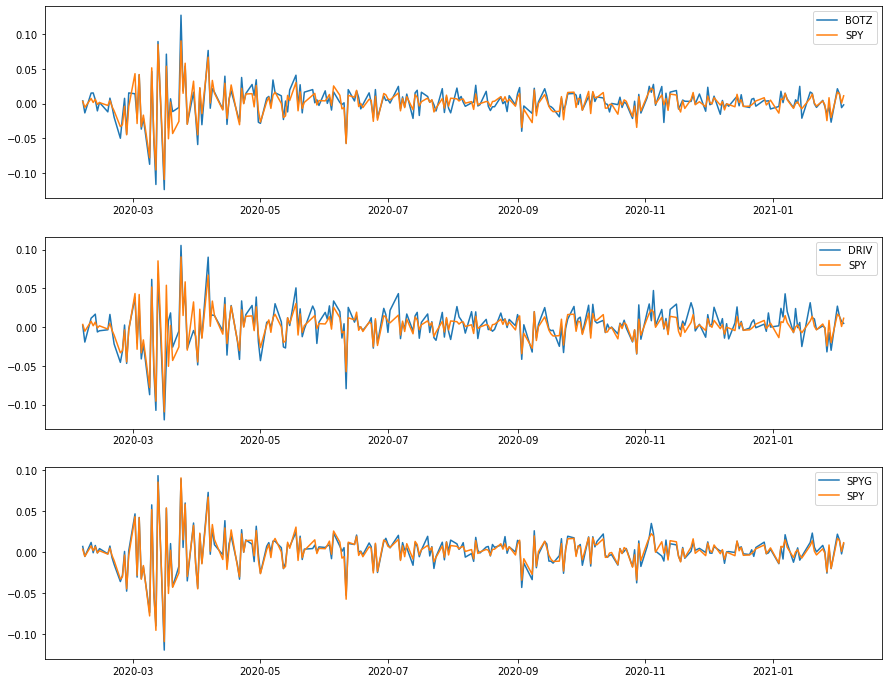

In [9]:
plt.subplot(3,1,1)
plt.plot(x, y1, label = "BOTZ")
plt.plot(x, y4, label = "SPY")
plt.legend()

plt.subplot(3,1,2)
plt.plot(x, y2, label = "DRIV")
plt.plot(x, y4, label = "SPY")
plt.legend()

plt.subplot(3,1,3)
plt.plot(x, y3, label = "SPYG")
plt.plot(x, y4, label = "SPY")
plt.legend()

plt.show()

The impact of covid19 pandamic can be seen from the graphs. Three ETFs have similar %return trend against S&P 500, while DRIV outperformed the most. 

Create a function to get the annualized beta of each ETF, against S&P 500 index.  

In [10]:
def get_beta(df):
    beta_values = []
    for y in df:
        beta = regr.fit(np.array(df['SPY']).reshape(-1,1),df[y]).coef_
        beta_values.append(beta)
    return beta_values[:-1]

In [11]:
get_beta(etf_returns)

[array([1.04168992]), array([1.02530021]), array([1.01953767])]

Create a function to construct the beta weighting model. The beta portfolio is assigned a target beta of 1.1 for the portfolio. 

In [12]:
def beta_portfolio(df, b_target):
    betas = np.array(get_beta(df))
    inc_dec = (b_target - betas)/ b_target
    weights = (1/len(betas)) * (1 + inc_dec)
    error = np.sum(weights) - 1
    adjusted_weights = (weights - (error/len(betas)))
    adjusted_weights = pd.DataFrame(adjusted_weights, index = etf_list[:-1],columns = ['Weights'])
    return adjusted_weights

In [13]:
weights = beta_portfolio(etf_returns,1.1)
weights

,Weights
BOTZ,0.329440
DRIV,0.334407
SPYG,0.336153


Create a mean variance optimization model. 

In [14]:
etfs = etf_prices.iloc[:,:-1]
etfs

,BOTZ,DRIV,SPYG
Date,,,
2020-02-05,22.389015,15.400795,43.848541
2020-02-06,22.478771,15.431658,44.145081
2020-02-07,22.179585,15.132980,43.907845
2020-02-10,22.518661,15.307209,44.421852
2020-02-11,22.867712,15.521261,44.382317
...,...,...,...
2021-01-29,33.849998,25.900000,55.040001
2021-02-01,34.580002,26.600000,56.240002
2021-02-02,35.070000,26.959999,57.070000


In [15]:
mean_weights = np.array([1/len(etfs.columns)] * len(etfs.columns))
mean_weights

array([0.33333333, 0.33333333, 0.33333333])

In [16]:
log_ret = np.log(etfs /etfs.shift(1))
log_ret

,BOTZ,DRIV,SPYG
Date,,,
2020-02-05,NaN,NaN,NaN
2020-02-06,0.004001,0.002002,0.006740
2020-02-07,-0.013399,-0.019545,-0.005388
2020-02-10,0.015172,0.011447,0.011639
2020-02-11,0.015382,0.013887,-0.000890
...,...,...,...
2021-01-29,-0.027104,-0.030421,-0.020501
2021-02-01,0.021337,0.026668,0.021568
2021-02-02,0.014071,0.013443,0.014650


In [17]:
log_ret.mean()

BOTZ    0.001751
DRIV    0.002270
SPYG    0.001076
dtype: float64

In [18]:
def ret_vol_sr(weights):
    ret = np.sum(weights * log_ret.mean()) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret / vol
    return np.array([ret, vol, sr])

In [19]:
ret_vol_sr(mean_weights)

array([0.42815968, 0.36202075, 1.18269375])

In [20]:
def neg_sharpe(weights):
    return ret_vol_sr(weights)[2] * -1

In [21]:
neg_sharpe(mean_weights)

-1.1826937468204333

In [22]:
bounds = ((0,1),(0,1),(0,1))

cons = ({'type':'eq', 'fun': lambda x: np.sum(x) -1})

In [23]:
guess = [0.33, 0.33, 0.33]

In [24]:
opt_weights = minimize(neg_sharpe, guess, method = 'SLSQP', bounds = bounds, constraints = cons)

In [25]:
opt_weights

     fun: -1.4373862578004275
     jac: array([ 9.24984962e-02, -1.49011612e-08,  4.09521997e-01])
 message: 'Optimization terminated successfully.'
    nfev: 20
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([1.66533454e-16, 1.00000000e+00, 0.00000000e+00])

In [26]:
opt_weights.x

array([1.66533454e-16, 1.00000000e+00, 0.00000000e+00])

In [27]:
ret_vol_sr(opt_weights.x)

array([0.57210124, 0.39801496, 1.43738626])

In [28]:
df = pd.DataFrame(opt_weights.x, columns=['weights'])
df

,weights
0,1.665335e-16
1,1.000000e+00
2,0.000000e+00
